## Project Statement:

Credit card fraud is a growing problem for both banks and customers. This project aims to build a machine learning model that can detect fraudulent transactions.

## About the Dataset:

This dataset contains credit card transactions made by European customers over two days in September 2013. There are 284,807 transactions, but only 492 are labeled as fraud, which makes up just 0.172% of the total data. The data is highly imbalanced, meaning there are far more legitimate transactions than fraudulent ones. The features in the dataset are all numerical, and some have been modified to protect customer privacy. Because fraud is so rare, we need to apply special methods, like resampling, to help our model correctly identify fraudulent transactions without being biased by the large number of regular transactions.

## Objectives:

Deal with the imbalance in the dataset by using techniques like oversampling and undersampling.
Test different machine learning models to find out which one performs best at detecting fraud.
Use evaluation metrics like ROC-AUC and F1 Score to make sure the model handles the imbalance well.
Build a fraud detection system that accurately finds fraud and minimizes mistakes, making it useful in real-time settings.







In [ ]:
# Import standard libraries for data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

# Import libraries for model building and evaluation
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score, roc_auc_score, roc_curve
from xgboost import XGBClassifier


### Preview the dataset

Preview of the dataset:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        

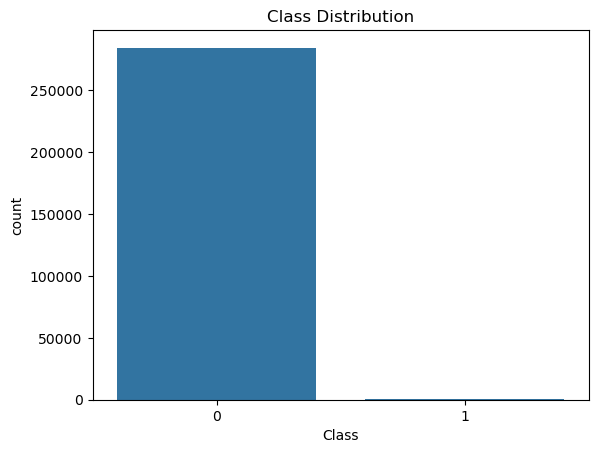


Class Distribution in Train Set:
 Class
0    0.998272
1    0.001728
Name: proportion, dtype: float64
Class Distribution in Validation Set:
 Class
0    0.998266
1    0.001734
Name: proportion, dtype: float64
Class Distribution in Test Set:
 Class
0    0.99828
1    0.00172
Name: proportion, dtype: float64

Train Set Size: (182276, 30), Validation Set Size: (45569, 30), Test Set Size: (56962, 30)


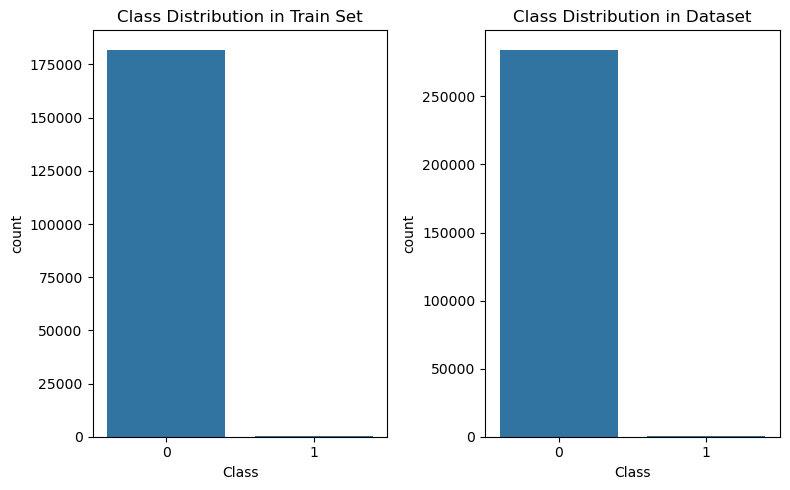

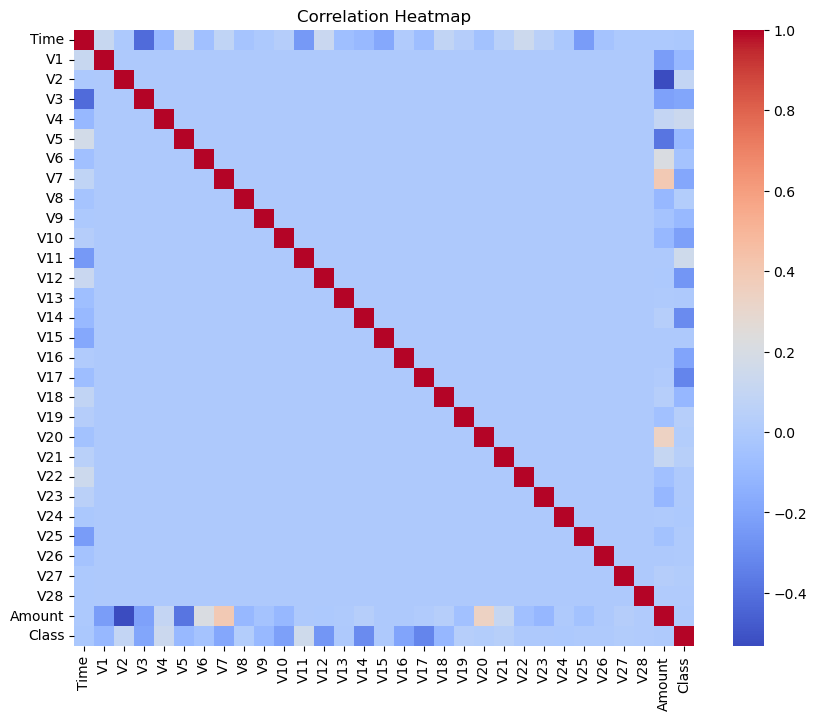

In [ ]:
# Load and preview the dataset
credit = pd.read_csv('creditcard.csv')
print("Preview of the dataset:")
print(credit.head())

# Check for missing values and data types
print("\nDataset Info:")
credit.info()
print("\nMissing Values in Each Column:")
print(credit.isnull().sum()[credit.isnull().sum() > 0])

# Separate features and target variable
X, y = credit.drop(columns='Class'), credit['Class']

# Check class distribution (fraud vs non-fraud)
sns.countplot(x=y)
plt.title('Class Distribution')
plt.show()

# Scale features using StandardScaler
X_scaled = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)

# Train-test split with stratification (80:20 ratio) and validation split (from training set)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
X_train_split, X_validation, y_train_split, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Display class distribution and dataset sizes
print("\nClass Distribution in Train Set:\n", y_train_split.value_counts(normalize=True))
print("Class Distribution in Validation Set:\n", y_validation.value_counts(normalize=True))
print("Class Distribution in Test Set:\n", y_test.value_counts(normalize=True))

print(f'\nTrain Set Size: {X_train_split.shape}, Validation Set Size: {X_validation.shape}, Test Set Size: {X_test.shape}')

# Plot class distribution in train and overall dataset
fig, axes = plt.subplots(1, 2, figsize=(8, 5))
sns.countplot(x=y_train_split, ax=axes[0])
axes[0].set_title("Class Distribution in Train Set")

sns.countplot(x=y, ax=axes[1])
axes[1].set_title("Class Distribution in Dataset")

plt.tight_layout()
plt.show()

# Optional: Correlation heatmap (for EDA)
plt.figure(figsize=(10, 8))
sns.heatmap(credit.corr(), cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


<a id = 'setup'></a>

In [ ]:
# Check the proportion of classes in training, validation, and test sets
print("\nProportion of classes in the training set:")
print(y_train_split.value_counts(normalize=True))

print("\nProportion of classes in the validation set:")
print(y_validation.value_counts(normalize=True))

print("\nProportion of classes in the test set:")
print(y_test.value_counts(normalize=True))

# Create a combined DataFrame of training data (features + target)
df_train = pd.concat([X_train_split, y_train_split], axis=1)
df_train.columns = list(X_train_split.columns) + ['Class']  # Rename the target column to 'Class' if necessary

# Display the number of non-fraudulent and fraudulent transactions in the training set
print(f"\nNumber of Non-Fraudulent Transactions in Training Set: {df_train['Class'].value_counts()[0]}")
print(f"Number of Fraudulent Transactions in Training Set: {df_train['Class'].value_counts()[1]}")



Proportion of classes in the training set:
Class
0    0.998272
1    0.001728
Name: proportion, dtype: float64

Proportion of classes in the validation set:
Class
0    0.998266
1    0.001734
Name: proportion, dtype: float64

Proportion of classes in the test set:
Class
0    0.99828
1    0.00172
Name: proportion, dtype: float64

Number of Non-Fraudulent Transactions in Training Set: 181961
Number of Fraudulent Transactions in Training Set: 315


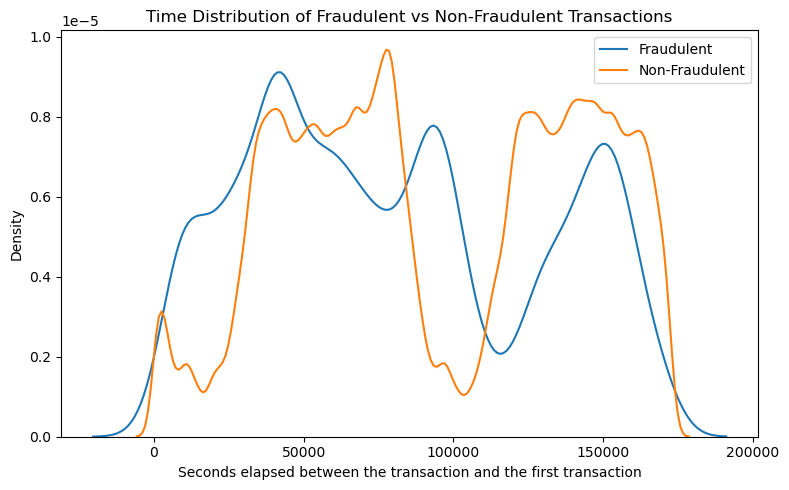

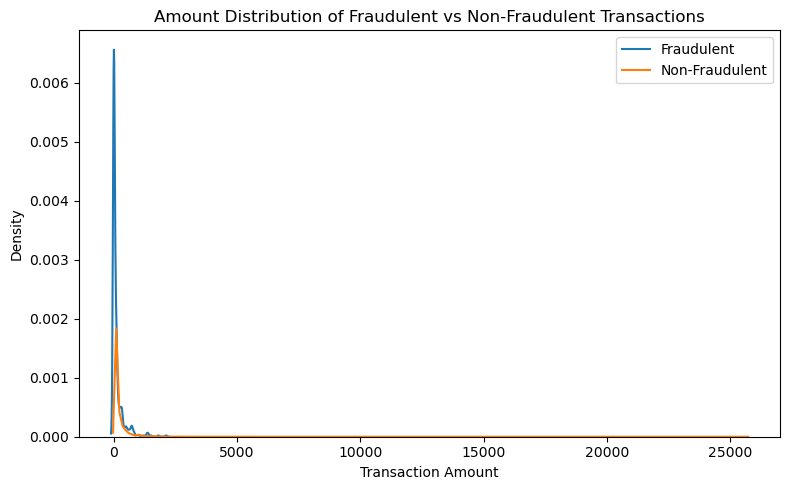

In [ ]:
# Load the dataset
credit = pd.read_csv('creditcard.csv')

# Separate fraudulent and non-fraudulent transactions
data_fraud = credit[credit['Class'] == 1]  # Fraudulent transactions
data_non_fraud = credit[credit['Class'] == 0]  # Non-fraudulent transactions

# Plot KDE distribution for 'Time' feature for both classes
plt.figure(figsize=(8, 5))
sns.kdeplot(data=data_fraud['Time'], label='Fraudulent', bw_adjust=0.5)
sns.kdeplot(data=data_non_fraud['Time'], label='Non-Fraudulent', bw_adjust=0.5)
plt.xlabel('Seconds elapsed between the transaction and the first transaction')
plt.title('Time Distribution of Fraudulent vs Non-Fraudulent Transactions')
plt.legend()
plt.tight_layout()
plt.show()

# Plot KDE distribution for 'Amount' feature for both classes
plt.figure(figsize=(8, 5))
sns.kdeplot(data=data_fraud['Amount'], label='Fraudulent', bw_adjust=0.5)
sns.kdeplot(data=data_non_fraud['Amount'], label='Non-Fraudulent', bw_adjust=0.5)
plt.xlabel('Transaction Amount')
plt.title('Amount Distribution of Fraudulent vs Non-Fraudulent Transactions')
plt.legend()
plt.tight_layout()
plt.show()


### Check skewness

Skewness of each feature:

Time      -0.035567
V1        -3.280650
V2        -4.624841
V3        -2.240144
V4         0.676289
V5        -2.425889
V6         1.826571
V7         2.553894
V8        -8.521899
V9         0.554677
V10        1.187134
V11        0.356504
V12       -2.278389
V13        0.065233
V14       -1.995165
V15       -0.308421
V16       -1.100960
V17       -3.844894
V18       -0.259879
V19        0.109191
V20       -2.037145
V21        3.592972
V22       -0.213256
V23       -5.875109
V24       -0.552496
V25       -0.415790
V26        0.576690
V27       -1.170203
V28       11.192032
Amount    16.977635
dtype: float64


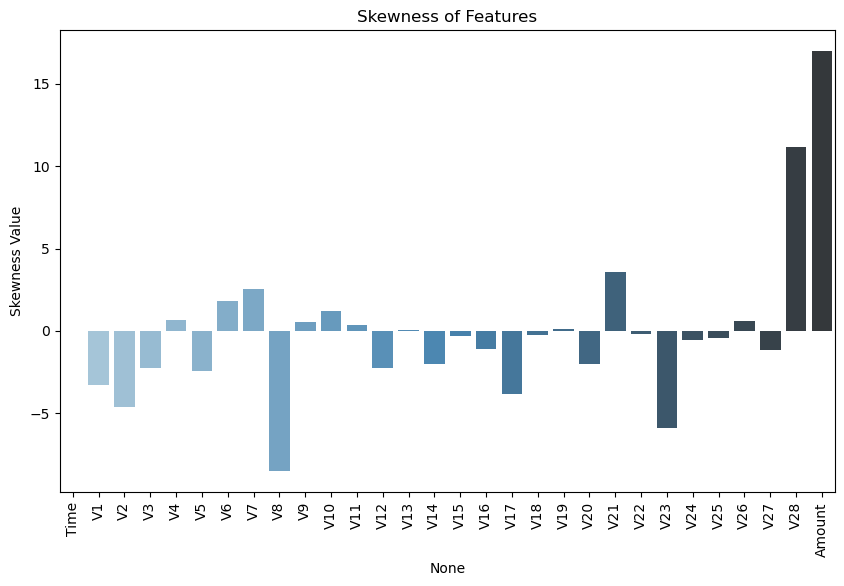


Highly Skewed Features (|Skewness| > 0.75):

V1        -3.280650
V2        -4.624841
V3        -2.240144
V5        -2.425889
V6         1.826571
V7         2.553894
V8        -8.521899
V10        1.187134
V12       -2.278389
V14       -1.995165
V16       -1.100960
V17       -3.844894
V20       -2.037145
V21        3.592972
V23       -5.875109
V27       -1.170203
V28       11.192032
Amount    16.977635
dtype: float64


In [ ]:
# Assuming the dataset has already been standardized (X_scaled)
# Check skewness for each feature in the standardized dataset
skewness_values = X_scaled.apply(lambda x: skew(x))

# Display skewness for each feature
print("Skewness of each feature:\n")
print(skewness_values)

# Visualize the skewness of features using a barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=skewness_values.index, y=skewness_values.values, hue=skewness_values.index, palette="Blues_d", legend=False)
plt.xticks(rotation=90)
plt.title('Skewness of Features')
plt.ylabel('Skewness Value')
plt.show()

# Identify highly skewed features
high_skew = skewness_values[abs(skewness_values) > 0.75]  # You can change the threshold as needed
print("\nHighly Skewed Features (|Skewness| > 0.75):\n")
print(high_skew)


<a id = 'epd'></a>

### Skewness Interpretation:

Symmetric: A skewness value between -0.5 and 0.5.

Moderately Skewed: A skewness value between -1 and -0.5 (left skew) or between 0.5 and 1 (right skew).

Highly Skewed: A skewness value less than -1 or greater than 1.

### Reducing Skewness in Features Using PowerTransformer for Improved Data Normalization

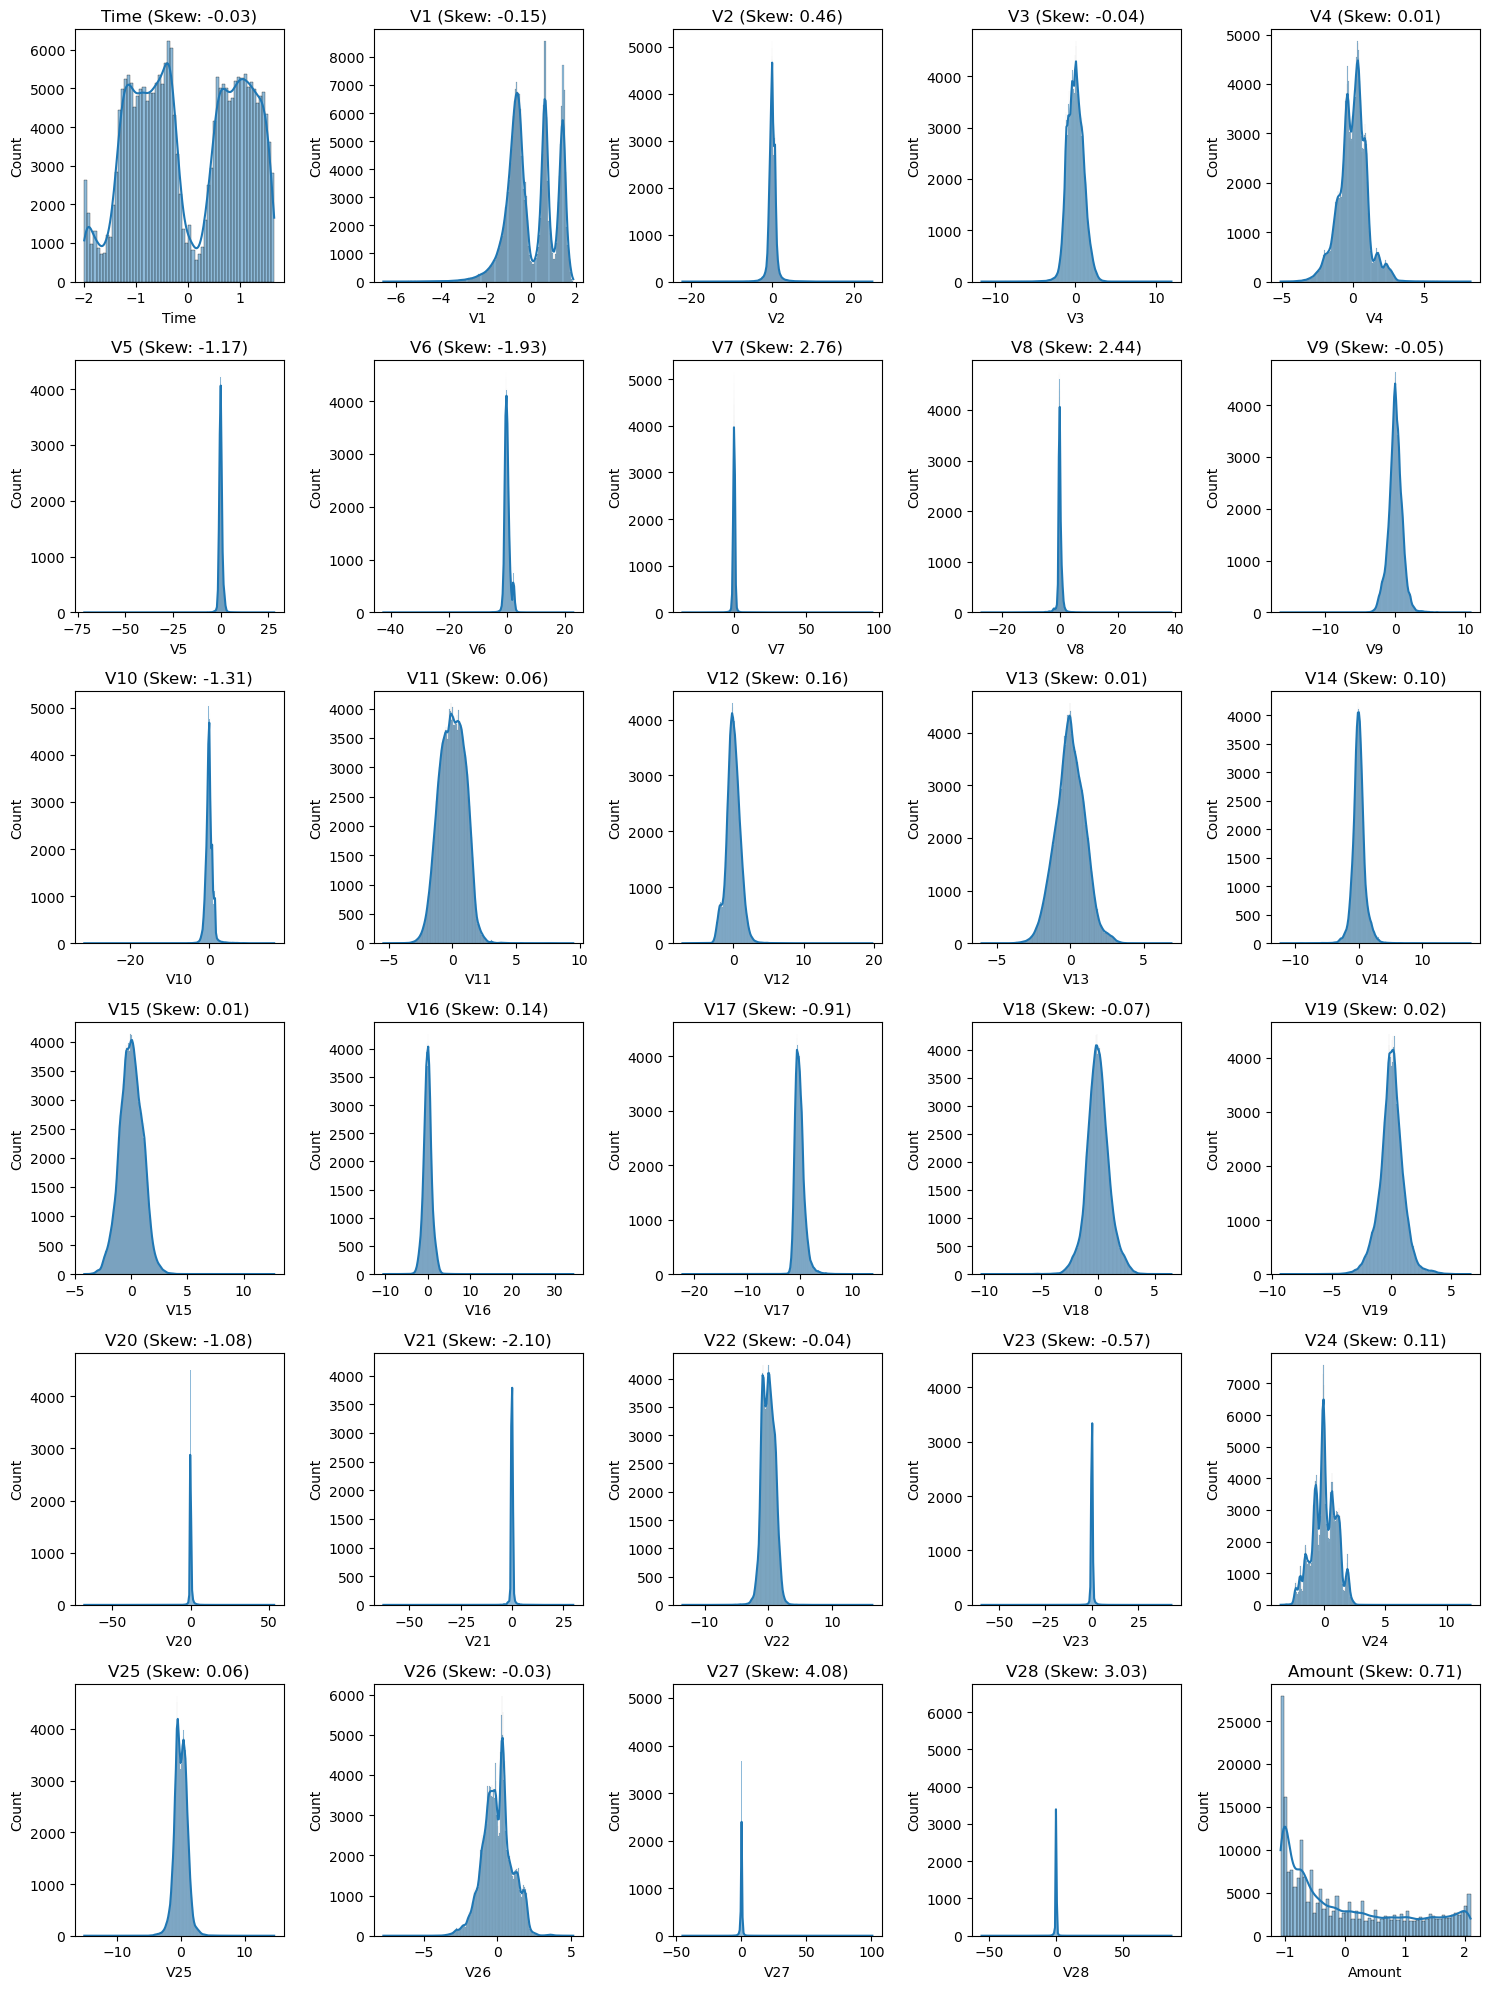

In [ ]:
# Define the list of columns (features) to transform
cols = X_train.columns

# Instantiate PowerTransformer (Yeo-Johnson for both positive and negative values)
pt = PowerTransformer(method='yeo-johnson', standardize=True)

# Fit and transform the training data, and transform the test data
X_train[cols] = pt.fit_transform(X_train[cols])
X_test[cols] = pt.transform(X_test[cols])

# Plot distributions of transformed features with skewness after transformation
plt.figure(figsize=(15, 20))  # Adjust figure size to fit all subplots
for i, col in enumerate(cols, start=1):
    plt.subplot(6, 5, i)  # Arrange plots in a 6x5 grid
    sns.histplot(X_train[col], kde=True)
    plt.title(f'{col} (Skew: {X_train[col].skew():.2f})')

# Optimize layout and show plot
plt.tight_layout()
plt.show()


<a id = 'sd'></a>

<a id = 'Setup'></a>

## "Challenges and Considerations in Model Building with Imbalanced Data":

Since the dataset contains many data points (284,807), and Oversampling creates even more, certain algorithms like SVM (Support Vector Machine) and KNN (K-Nearest Neighbors) were not used for model building. SVM is inefficient with large datasets because it requires a lot of computational power and time, especially when using techniques like K-Fold cross-validation for tuning. Similarly, KNN is not memory-efficient and becomes very slow with large datasets, as it needs to store all data points and calculate distances for each new data point. For these reasons, both algorithms were avoided due to their computational demands.

###### Random Forest
though generally more efficient, was also avoided in some hyperparameter tuning cases when using oversampling, as it can be slow and resource-intensive with large datasets.

Since the data is very imbalanced, with only 0.17% of transactions being fraudulent, accuracy isn’t a reliable measure. A model could predict all transactions as non-fraud and still achieve over 99% accuracy, which doesn’t help identify fraud. Instead, the ROC-AUC score is used for a fair evaluation of the model. The ROC curve helps assess performance at various classification thresholds, and we aim to find the best threshold where the false positives and false negatives are minimized. After finding this optimal threshold, we use the F1 score to evaluate how well the model balances precision and recall.

## Model  
#### XGBoost

In [ ]:
!pip install xgboost;

Fitting 3 folds for each of 9 candidates, totalling 27 fits


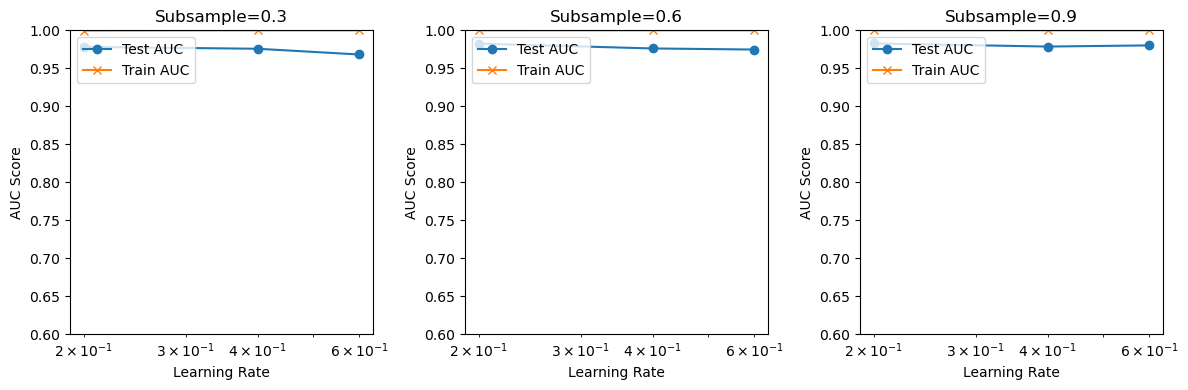

In [ ]:
# Define hyperparameter grid for tuning
param_grid = {
    'learning_rate': [0.2, 0.4, 0.6],
    'subsample': [0.3, 0.6, 0.9]
}

# Instantiate XGBoost model with fixed max_depth and n_estimators
xgb_model = XGBClassifier(max_depth=2, n_estimators=200)

# Set up GridSearchCV with 3-fold cross-validation, using ROC-AUC as scoring metric
model_cv = GridSearchCV(estimator=xgb_model,
                        param_grid=param_grid,
                        scoring='roc_auc',
                        cv=3,
                        verbose=1,
                        return_train_score=True)

# Fit the model to the training data
model_cv.fit(X_train, y_train)

# Convert cross-validation results to a DataFrame for easier access and visualization
cv_results = pd.DataFrame(model_cv.cv_results_)

# Plot AUC for different combinations of learning_rate and subsample
plt.figure(figsize=(12, 4))
for idx, subsample in enumerate(param_grid['subsample'], start=1):
    plt.subplot(1, len(param_grid['subsample']), idx)

    # Filter the results for the specific subsample value
    df = cv_results[cv_results['param_subsample'] == subsample]

    # Plot the training and testing AUC scores
    plt.plot(df["param_learning_rate"], df["mean_test_score"], label='Test AUC', marker='o')
    plt.plot(df["param_learning_rate"], df["mean_train_score"], label='Train AUC', marker='x')

    plt.xlabel('Learning Rate')
    plt.ylabel('AUC Score')
    plt.title(f"Subsample={subsample}")
    plt.ylim([0.60, 1])
    plt.legend(loc='upper left')
    plt.xscale('log')  # Log scale for the x-axis

plt.tight_layout()
plt.show()


In [ ]:
# Function to display metrics
def display_metrics(y_true, y_pred, y_pred_proba, set_name="Set"):
    conf_matrix = confusion_matrix(y_true, y_pred)
    print(f"\n{set_name} Confusion Matrix:\n{conf_matrix}")
    print(f"{set_name} Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"{set_name} Sensitivity (Recall): {conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0]):.4f}")
    print(f"{set_name} Specificity: {conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1]):.4f}")
    print(f"{set_name} F1-Score: {f1_score(y_true, y_pred):.4f}")
    print(f"{set_name} ROC-AUC: {roc_auc_score(y_true, y_pred_proba):.4f}")
    print(f"\n{set_name} Classification Report:\n", classification_report(y_true, y_pred))

# Plot ROC Curve
def draw_roc(actual, predicted_probs):
    fpr, tpr, _ = roc_curve(actual, predicted_probs)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc_score(actual, predicted_probs):.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


Training Confusion Matrix:
[[227451      0]
 [     0    394]]
Training Accuracy: 1.0000
Training Sensitivity (Recall): 1.0000
Training Specificity: 1.0000
Training F1-Score: 1.0000
Training ROC-AUC: 1.0000

Training Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       1.00      1.00      1.00       394

    accuracy                           1.00    227845
   macro avg       1.00      1.00      1.00    227845
weighted avg       1.00      1.00      1.00    227845



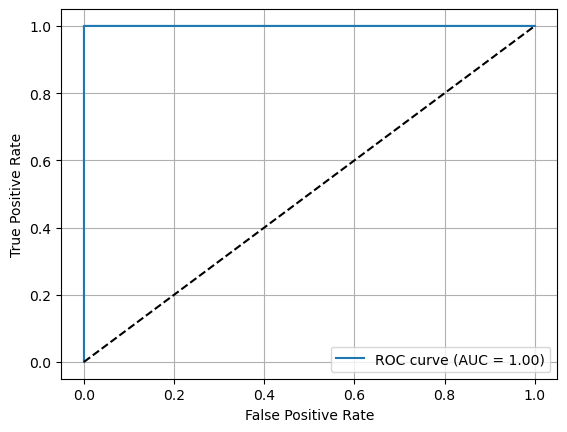

In [ ]:
from xgboost import XGBClassifier

# Retrieve the best hyperparameters from GridSearchCV
best_params = model_cv.best_params_

# Fit the model with the best hyperparameters on the training data
xgb_imb_model = XGBClassifier(**best_params)
xgb_imb_model.fit(X_train, y_train)

# Predictions and predicted probabilities for the training set
y_train_pred = xgb_imb_model.predict(X_train)
y_train_pred_proba = xgb_imb_model.predict_proba(X_train)[:, 1]

# Display metrics for the training set
display_metrics(y_train, y_train_pred, y_train_pred_proba, "Training")

# Plot ROC curve for the training set
draw_roc(y_train, y_train_pred_proba)



Test Confusion Matrix:
[[56858     6]
 [   19    79]]
Test Accuracy: 0.9996
Test Sensitivity (Recall): 0.8061
Test Specificity: 0.9999
Test F1-Score: 0.8634
Test ROC-AUC: 0.9724

Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.93      0.81      0.86        98

    accuracy                           1.00     56962
   macro avg       0.96      0.90      0.93     56962
weighted avg       1.00      1.00      1.00     56962



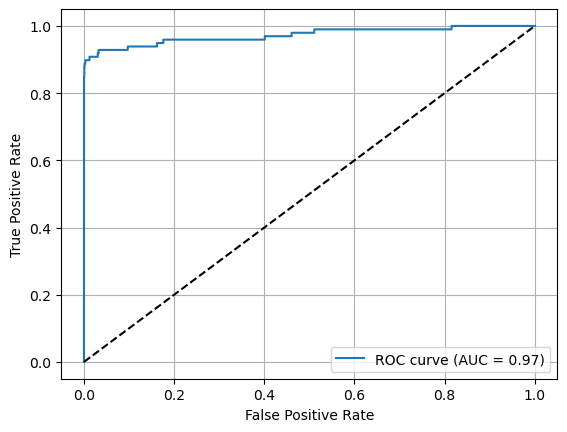

In [ ]:
# Predictions and predicted probabilities on the test set
y_test_pred = xgb_imb_model.predict(X_test)
y_test_pred_proba = xgb_imb_model.predict_proba(X_test)[:, 1]

# Display metrics for the test set
display_metrics(y_test, y_test_pred, y_test_pred_proba, "Test")

# Plot ROC curve for the test set
draw_roc(y_test, y_test_pred_proba)


## Model
#### Logistic Regression

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters: {'C': 1}
Best ROC-AUC Score: 0.9811


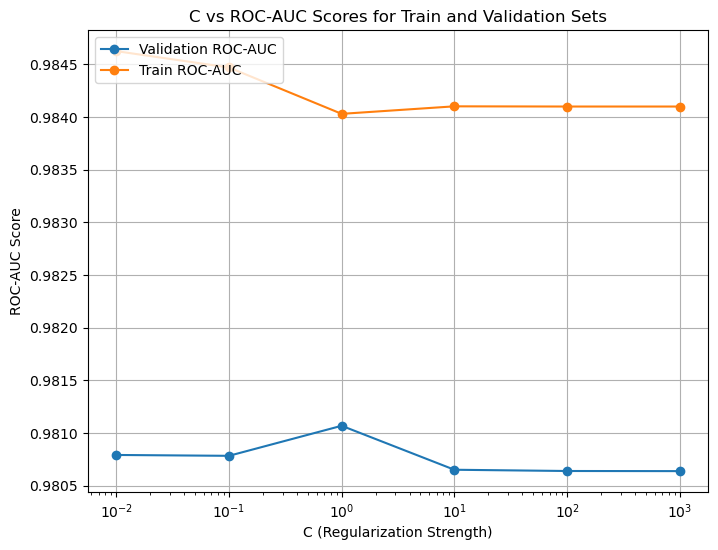


Test Confusion Matrix:
[[56850    14]
 [   33    65]]
Test Accuracy: 0.9992
Test Sensitivity (Recall): 0.6633
Test Specificity: 0.9998
Test F1-Score: 0.7345
Test ROC-AUC: 0.9695

Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.82      0.66      0.73        98

    accuracy                           1.00     56962
   macro avg       0.91      0.83      0.87     56962
weighted avg       1.00      1.00      1.00     56962



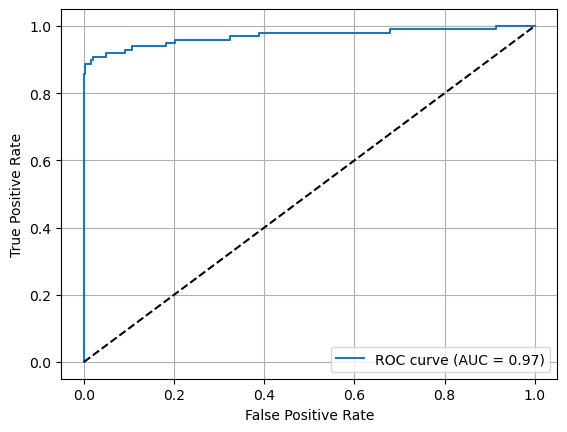

In [ ]:
# Define cross-validation strategy with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=4)

# Set hyperparameter grid for Logistic Regression (C controls regularization)
param_grid = {"C": [0.01, 0.1, 1, 10, 100, 1000]}

# Use GridSearchCV to find the best hyperparameters based on ROC-AUC score
grid_cv = GridSearchCV(estimator=LogisticRegression(),
                       param_grid=param_grid,
                       scoring='roc_auc',
                       cv=kf,
                       verbose=1,
                       return_train_score=True)

# Fit the model to the training data
grid_cv.fit(X_train, y_train)

# Convert the GridSearchCV results to a DataFrame for better viewing
cv_results = pd.DataFrame(grid_cv.cv_results_)

# Display the best hyperparameters and their corresponding score
print(f"Best Parameters: {grid_cv.best_params_}")
print(f"Best ROC-AUC Score: {grid_cv.best_score_:.4f}")

# Plot C values vs train and test ROC-AUC scores
plt.figure(figsize=(8, 6))
plt.plot(cv_results['param_C'], cv_results['mean_test_score'], label='Validation ROC-AUC', marker='o')
plt.plot(cv_results['param_C'], cv_results['mean_train_score'], label='Train ROC-AUC', marker='o')
plt.xlabel('C (Regularization Strength)')
plt.ylabel('ROC-AUC Score')
plt.title('C vs ROC-AUC Scores for Train and Validation Sets')
plt.xscale('log')  # Logarithmic scale for C values
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Fit the best model on the training data
best_log_reg = grid_cv.best_estimator_

# Predictions and predicted probabilities for the test set
y_test_pred = best_log_reg.predict(X_test)
y_test_pred_proba = best_log_reg.predict_proba(X_test)[:, 1]

# Display metrics for the test set
display_metrics(y_test, y_test_pred, y_test_pred_proba, "Test")

# Plot ROC curve for the test set
draw_roc(y_test, y_test_pred_proba)



Training Confusion Matrix:
[[227424     27]
 [   136    258]]
Training Accuracy: 0.9993
Training Sensitivity (Recall): 0.6548
Training Specificity: 0.9999
Training F1-Score: 0.7599
Training ROC-AUC: 0.9839

Training Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.91      0.65      0.76       394

    accuracy                           1.00    227845
   macro avg       0.95      0.83      0.88    227845
weighted avg       1.00      1.00      1.00    227845


Test Confusion Matrix:
[[56850    14]
 [   33    65]]
Test Accuracy: 0.9992
Test Sensitivity (Recall): 0.6633
Test Specificity: 0.9998
Test F1-Score: 0.7345
Test ROC-AUC: 0.9695

Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.82      0.66      0.73        98

    accuracy                           1.00     56962
   ma

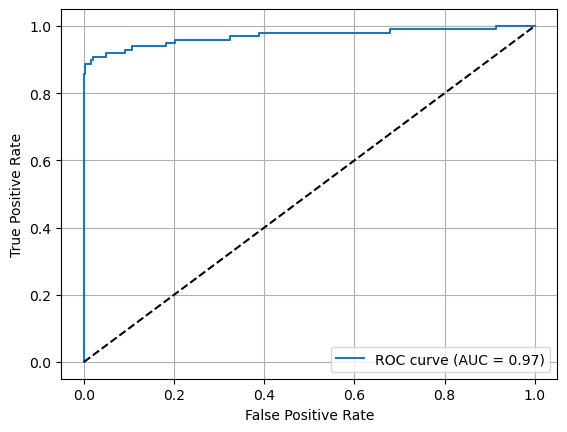

In [ ]:
# Train the model with the best C from GridSearchCV
best_C = grid_cv.best_params_['C']
logistic_best_model = LogisticRegression(C=best_C).fit(X_train, y_train)

# Training set evaluation
y_train_pred = logistic_best_model.predict(X_train)
y_train_pred_proba = logistic_best_model.predict_proba(X_train)[:, 1]
display_metrics(y_train, y_train_pred, y_train_pred_proba, "Training")

# Test set evaluation
y_test_pred = logistic_best_model.predict(X_test)
y_test_pred_proba = logistic_best_model.predict_proba(X_test)[:, 1]
display_metrics(y_test, y_test_pred, y_test_pred_proba, "Test")

# Plot ROC curve for the test set
draw_roc(y_test, y_test_pred_proba)


<a id = 'o'></a>